**Twitter Sentiment Analysis for COVID-19:**

This project aims to undestand the sentiment of the general public about the ongoing COVID-19 pandemic through tweets posted in twitter.

Brief description of the process:
1. Collect training data set with pre-classified sentiments (IEEE dataset)
2. Collect tweets for test data throught twitter api
3. Perform text processing on the collected test data
4. Train the training data with an appropriate classifier
5. Fit the test data on the trained model to predict the sentiment of each tweet
6. Project the overall sentiment



In [175]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from scipy.sparse import hstack
from textblob import TextBlob
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [157]:
traindata = pd.read_csv('cleaned_tweets.csv')

traindata=traindata.drop(columns='unix')
traindata=traindata.drop(columns='id')

tweets = traindata['tweet']
tweetslower = [x.lower() for x in tweets]
tweetslower = [x.replace("'","") for x in tweetslower]       
        
traindata=traindata.drop(columns='tweet')
traindatadf = pd.DataFrame()
traindatadf['tweet'] = tweetslower

def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity == 0:
    	return 0
    elif analysis.sentiment.polarity > 0:
    	return 1
    else:
    	return -1
    
sentiments_using_textblob = traindatadf.tweet.apply(lambda t: fetch_sentiment_using_textblob(t))
traindatadf['sentiment']=sentiments_using_textblob

traindatadf['tweet'].replace('', np.nan,inplace=True)

traindatadf.dropna(subset=['tweet'], inplace=True)
print(traindatadf.head())


                                               tweet  sentiment
0                        [many, people, wanna, work]          1
1                              [nothing, see, folks]          0
2                  [homie, pg, done, caught, corona]          0
3  [fuck, ya, gay, cunt, ya, probables, fucking, ...         -1
4  [logan, act, corona, butt, hopefully, met, nad...          0


In [220]:
traindf=traindatadf
traindf=traindf[:400000]
print((traindf.head()))

                                               tweet  sentiment
0                        [many, people, wanna, work]          1
1                              [nothing, see, folks]          0
2                  [homie, pg, done, caught, corona]          0
3  [fuck, ya, gay, cunt, ya, probables, fucking, ...         -1
4  [logan, act, corona, butt, hopefully, met, nad...          0


In [228]:
#reading test data - mined from twitter

testdf = pd.read_csv('minedtweets.csv')
testdf=testdf.drop(columns=testdf.columns[0])

print(type(testdf['tweet'][0]))
#replacing empty strings
testdf['tweet'].replace('', np.nan,inplace=True)

#dropping duplicates
testdf=testdf.drop_duplicates(subset='tweet')
testdf = testdf[testdf['tweet'].notnull()]
testdf=testdf[:40000]


testdf['tweet'] = testdf.tweet.apply(lambda x: x.split())
print(testdf.shape)
testdf.to_csv('test-tweets.csv')

                                                   tweet  sentiment
0      [prepared, take, care, family, naturally, must...          1
1      [coronavirus, corona, covid19, virus, covid_19...          1
2      [wake, everything, going, world, today, necess...          0
3      [ima, calls, proposed, protests, meeting, amit...          0
4                                  [coronavirusoutbreak]          0
...                                                  ...        ...
88571  [amazing, --, evidence, 1000s, scientists, sin...          1
88575  [absolutely, compulsory, commentators, us, cal...          1
88579  [politicians, yammer, abt, ``, herd, immunity,...          0
88587  [covid19, sarscov2, coronavirus, coronavirus, ...          0
88589  [called, democrat, hoax, 45,000, americans, di...          0

[40000 rows x 2 columns]


In [222]:
#merging train and test data frames for feature generation

df = traindf.append(testdf)
print(type(df['tweet']))

<class 'pandas.core.series.Series'>


In [223]:
#Generating feature vectors and training the data
tfidfvectorizer = TfidfVectorizer()
tfidf = tfidfvectorizer.fit_transform(df['tweet'])


AttributeError: 'list' object has no attribute 'lower'

In [185]:
target_variable = df['sentiment']
x_train = tfidf[:400000]
x_test = tfidf[-40000:]
y_train = target_variable[:400000]
y_test = target_variable[-40000:]
print(len(y_test))

40000


In [188]:
lr = LogisticRegression(solver='lbfgs',max_iter=1000)
rf = RandomForestClassifier()
gbm = GradientBoostingClassifier()
dt = DecisionTreeClassifier()

classifier_dict={lr:"Logistic Regression", rf:"Random Forest", gbm:"Gradient Boosting Machine", dt:"Decision Tree"}
classifiers=[lr,rf,dt]
accuracy=[]
f1score=[]

In [189]:
#Fitting the model with train data and testing
for classifier in classifiers:
    print("\nModel: " + classifier_dict[classifier])
    classifier.fit(x_train,y_train)
    df2=pd.DataFrame(classifier.predict(x_test))
    df2.columns=['predicted_sentiments']
    print('----------Fraction of sentiment---------------')
    print(round(df2['predicted_sentiments'].value_counts(normalize=True)*100,2))
    accuracy.append(round(accuracy_score(y_test,classifier.predict(x_test))*100,2))
    f1score.append(round(f1_score(y_test, classifier.predict(x_test), average='weighted') * 100, 2))


Model: Logistic Regression
----------Fraction of sentiment---------------
 0    68.37
 1    22.13
-1     9.50
Name: predicted_sentiments, dtype: float64

Model: Random Forest
----------Fraction of sentiment---------------
 0    66.82
 1    22.86
-1    10.33
Name: predicted_sentiments, dtype: float64

Model: Decision Tree
----------Fraction of sentiment---------------
 0    64.28
 1    24.50
-1    11.22
Name: predicted_sentiments, dtype: float64


In [190]:

print("Logistic Regression")
print(str("Accuracy: ") + str(accuracy[0]))
print(str("F1 score: ") + str(f1score[0]))

print("\nRandom Forest")
print(str("Accuracy: ") + str(accuracy[1]))
print(str("F1 score: ") + str(f1score[1]))

print("\nDecision Tree")
print(str("Accuracy: ") + str(accuracy[2]))
print(str("F1 score: ") + str(f1score[2]))

Logistic Regression
Accuracy: 93.72
F1 score: 93.56

Random Forest
Accuracy: 93.17
F1 score: 93.04

Decision Tree
Accuracy: 95.86
F1 score: 95.86


                                         test tweets  test sentiment  \
0                        [many, people, wanna, work]             1.0   
3  [fuck, ya, gay, cunt, ya, probables, fucking, ...            -1.0   
5          [house, close, hospital, handles, corona]            -1.0   
6                   [victim, corona, virus, america]             1.0   
8  [anyone, else, self, crapping, corona, virus, ...             1.0   

                                               tweet  
0  prepared take care family naturally must-watch...  
3  ima calls proposed protests meeting amit shah ...  
5  young people falling seriously ill covid19 new...  
6  please need support make face shields distribu...  
8  prime minister narendra modi interact chief mi...  


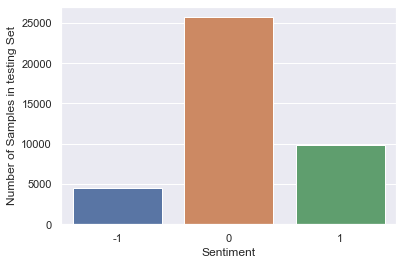

In [204]:
sns.set(style="darkgrid")
ax = sns.countplot(x="predicted_sentiments", data=df2)
ax.set_ylabel("Number of Samples in testing Set")
ax.set_xlabel("Sentiment")
df2['predicted_sentiments'].value_counts()
df3['tweet']=testdf['tweet']
print(df3.head())
#print(testdf)

In [35]:
#Hyper parameter tuning

param_grid = {
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'solver' : ['lbfgs','newton-cg','liblinear'],
              'max_iter' : [100, 500, 1000]
             }

gridsearch = GridSearchCV(lr, param_grid)
lr_new = gridsearch.fit(x_train,y_train)



/Users/sudeepkrishna/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

Best hyperparameters: {'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}

----------Count of sentiment---------------
 1.0    63915
-1.0    36085
Name: prediction, dtype: int64

----------Percentage of sentiment---------------
 1.0    0.63915
-1.0    0.36085
Name: prediction, dtype: float64

accuracy : 88.72
f1 score : 88.63


Text(0.5, 0, 'Sentiment')

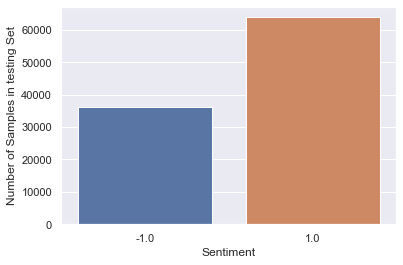

In [79]:
print('Best hyperparameters:', lr_new.best_params_)
df2=pd.DataFrame(lr_new.predict(x_test))
df2.columns=['prediction']

print('\n----------Count of sentiment---------------')
print(df2['prediction'].value_counts())
print('\n----------Percentage of sentiment---------------')
print(df2['prediction'].value_counts(normalize=True))

print('\naccuracy :',round(accuracy_score(y_test,lr_new.predict(x_test))*100,2))
print('f1 score :',round(f1_score(y_test, lr_new.predict(x_test), average='weighted') * 100, 2))

